In [1]:
import os
os.chdir('/Users/xinglongli/git_local/sts-jax')

# Structural time series (STS) model with Poisson likelihood

In [2]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np

import sts_jax.structural_time_series.sts_model as sts

## Synthetic Data

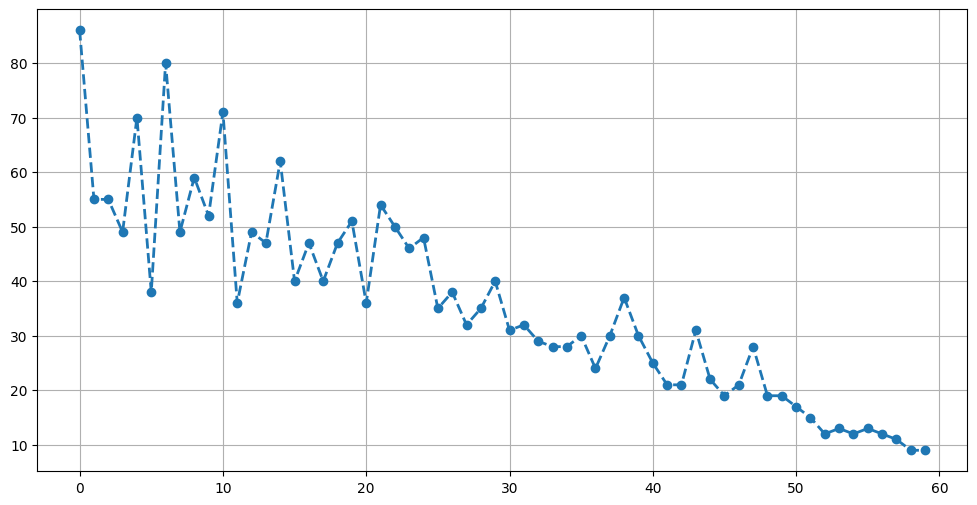

In [3]:
num_training_steps = 60
num_forecast_steps = 30
num_steps = num_training_steps

np.random.seed(1)
counts = np.round(3 + np.random.lognormal(np.log(np.linspace(
    num_steps, 5, num=num_steps)), 0.2, size=num_steps))
counts = counts.astype(np.float32)
counts_training = counts[:num_training_steps]
plt.figure(figsize=(12, 6))
plt.plot(counts, lw=2, linestyle='--', marker='o')
plt.grid()

### Plot functions

In [10]:
def plot_forecast(model, param_samples, obs_time_series):
    # Forecast
    forecasts = model.forecast(param_samples, obs_time_series, num_forecast_steps,
                               num_forecast_samples=1000)
    forecasts = jnp.concatenate(forecasts, axis=0).squeeze()
    forecast_means = jnp.mean(forecasts, axis=0)
    forecast_quantiles = jnp.quantile(forecasts, jnp.array([0.2, 0.8]), axis=0)

    # Plot the forecast
    steps = jnp.arange(num_steps)
    training_steps = jnp.arange(num_training_steps)
    forecast_steps = num_training_steps + jnp.arange(num_forecast_steps)
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(steps, counts, lw=2, linestyle='--', marker='o', label='Observation', color='C0')
    ax.plot(forecast_steps, forecast_means, lw='2', linestyle='--', marker='o',
            color='C1', label='Forecast')
    ax.fill_between(forecast_steps,
                    forecast_quantiles[0], forecast_quantiles[1],
                    color='C1', alpha=0.3)
    ax.set_ylabel("Counts")
    ax.set_xlabel("Steps")
    ax.legend()
    ax.grid()
    fig.suptitle("Forecast of time series with Poisson observation", fontsize=15)

## Implementation via CMGF

In [5]:
counts = jnp.array(counts[:num_steps, None])
counts_training = counts[:num_training_steps]
counts_predict = counts[-num_forecast_steps:]

### Build the STS model

In [6]:
trend = sts.LocalLinearTrend()
model = sts.StructuralTimeSeries([trend],
                                 obs_distribution='Poisson',
                                 obs_time_series=counts_training)

### Model fitting

In [7]:
# Fit the model using HMC
obs_time_series = counts_training
key = jr.PRNGKey(0)

In [8]:
opt_param, _losses = model.fit_mle(obs_time_series, num_steps=1000)
param_samples, _log_probs = model.fit_hmc(
    num_samples=200, obs_time_series=obs_time_series, initial_params=opt_param)

Running window adaptation


### Forecast

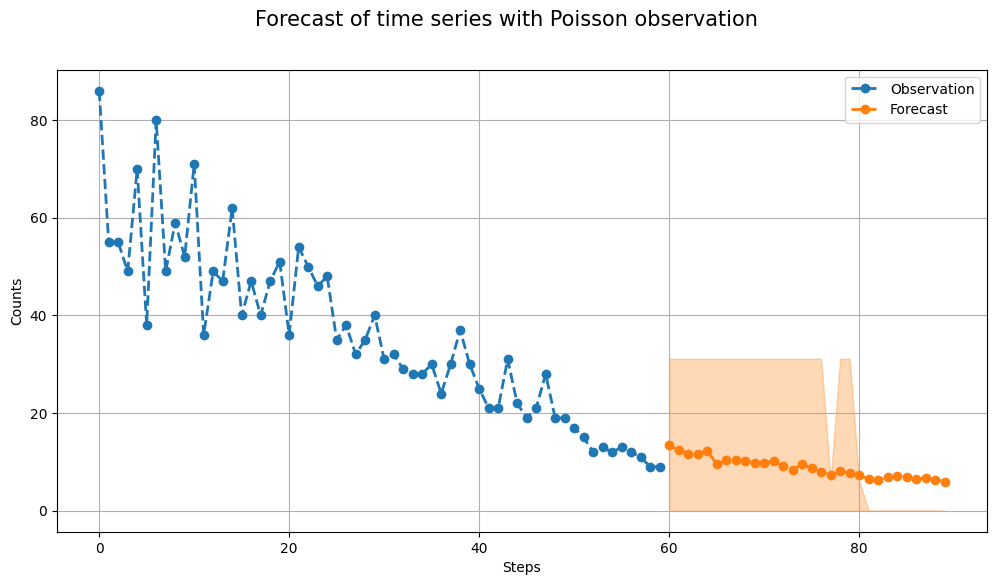

In [11]:
plot_forecast(model, opt_param, obs_time_series)